In [1]:
import xml.etree.ElementTree as ET 
import gzip
from xml.etree.cElementTree import ElementTree

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

import statistics

In [2]:
data_path = "/media/aodiallo/Data/MATSIM/data"
SOURCE = "edgt_lyon_2015/zf_lyon/ZF_Lyon_Metropolis.shp"

In [3]:
df_iris = gpd.read_file("%s/%s" % (data_path, SOURCE))[[
        "codeiris", "commune", "insee", "geometry"
    ]].rename(columns = {
        "codeiris": "iris_id",
        "commune": "commune_name",
        "insee": "commune_id"
    })

df_iris.crs = "EPSG:2154"

df_iris["iris_id"] = df_iris["iris_id"].astype(str).astype("category")
df_iris["commune_id"] = df_iris["commune_id"].astype(str).astype("category")
df_iris["commune_name"] = df_iris["commune_name"].astype(str).astype("category")

In [4]:
df_iris

,iris_id,commune_name,commune_id,geometry
0,690030000,Albigny-sur-Saône,69003,"POLYGON ((842472.000 6532458.900, 842430.200 6..."
1,690290101,Bron,69029,"POLYGON ((848185.000 6517805.100, 848179.300 6..."
2,690290102,Bron,69029,"POLYGON ((848185.000 6517805.100, 848193.700 6..."
3,690290103,Bron,69029,"POLYGON ((848473.000 6517709.800, 848475.200 6..."
4,690290104,Bron,69029,"POLYGON ((849043.400 6517050.700, 849006.900 6..."
...,...,...,...,...
507,693890502,Lyon 9e Arrondissement,69389,"POLYGON ((839868.200 6520100.400, 839873.900 6..."
508,693890604,Lyon 9e Arrondissement,69389,"POLYGON ((839222.200 6522347.200, 839220.400 6..."
509,693890605,Lyon 9e Arrondissement,69389,"POLYGON ((839317.700 6522667.900, 839321.800 6..."
510,693890606,Lyon 9e Arrondissement,69389,"POLYGON ((839218.700 6521610.100, 839226.100 6..."


<AxesSubplot:>

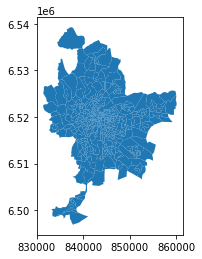

In [5]:
df_iris.plot()

In [6]:
def is_in_urban_area(df, x ,y):
    point = Point(x,y)
    table = df.contains(point)
    for x in table:
        if x== True:
            return(True)
    return(False)

In [7]:
print(df_iris["commune_id"].unique())

['69003', '69029', '69033', '69034', '69040', ..., '69385', '69386', '69387', '69388', '69389']
Length: 67
Categories (67, object): ['69003', '69029', '69033', '69034', ..., '69386', '69387', '69388', '69389']


In [8]:
### Urban aera selection : Lyon (1-9 arrondissement) : Lyon 1er Arrondissement 69381-69389, Villeurbanne 69266,
### Bron 69029, Vaulx-en-Velin 69256, Caluire-et-Cuire 69034

In [9]:
urban_cities = ["69381", "69382", "69383", "69384", "69385", "69386", "69387", "69388", "69389", "69266", "69029", "69256", "69034"]

In [10]:
df_iris_urban = df_iris[df_iris["commune_id"].isin(urban_cities)]

In [11]:
df_iris_urban

,iris_id,commune_name,commune_id,geometry
1,690290101,Bron,69029,"POLYGON ((848185.000 6517805.100, 848179.300 6..."
2,690290102,Bron,69029,"POLYGON ((848185.000 6517805.100, 848193.700 6..."
3,690290103,Bron,69029,"POLYGON ((848473.000 6517709.800, 848475.200 6..."
4,690290104,Bron,69029,"POLYGON ((849043.400 6517050.700, 849006.900 6..."
5,690290201,Bron,69029,"POLYGON ((848971.400 6517848.300, 848985.600 6..."
...,...,...,...,...
507,693890502,Lyon 9e Arrondissement,69389,"POLYGON ((839868.200 6520100.400, 839873.900 6..."
508,693890604,Lyon 9e Arrondissement,69389,"POLYGON ((839222.200 6522347.200, 839220.400 6..."
509,693890605,Lyon 9e Arrondissement,69389,"POLYGON ((839317.700 6522667.900, 839321.800 6..."
510,693890606,Lyon 9e Arrondissement,69389,"POLYGON ((839218.700 6521610.100, 839226.100 6..."


<AxesSubplot:>

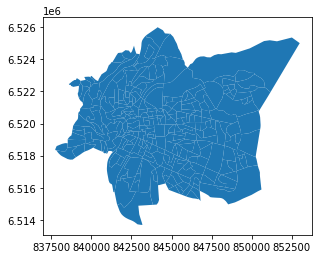

In [12]:
df_iris_urban.plot()

In [13]:
def population_stats(population):
    number=len(population)
    print("Taille population :   ",number)
    driving_lic_poss = len([person for person in population.iter('person') if person[0][6].text=="yes"])
    print("Titulaires du permis :",driving_lic_poss," soit ", driving_lic_poss/number * 100, "%")
    women = len([person for person in population.iter('person') if person[0][13].text=="f"])
    print("Femmes :              ", women, " soit ", women/number * 100, "%")
    men = len([person for person in population.iter('person') if person[0][13].text=="m"])
    print("Hommes :              ", men, " soit ", men/number * 100, "%")
    print("Revenu moyen :        ",statistics.mean([float(person[0][9].text) for person in population.iter('person')]))
    pt_sub = len([person for person in population.iter('person') if person[0][7].text=="true"])
    print("Abonnés aux pt :  ", pt_sub, " soit ", pt_sub/number * 100, "%")
    #return members
    #CSMembership(members,companies,CSMembership_file

In [14]:
initialPlanFile = '/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/5_pr_100/lyon_metropole_population.xml.gz'
treePopulation = ET.parse(gzip.open(initialPlanFile,'r'))
population  = treePopulation.getroot()

In [15]:
agent = population[1]
plan = agent[1]
home = plan[0]
x = float(home.get("x"))
y = float(home.get("y"))
x
point = Point(x,y)

is_in_urban_area(df_iris_urban, x,y)

True

In [16]:
population_stats(population)

Taille population :    63171
Titulaires du permis : 39652  soit  62.76930870177772 %
Femmes :               32854  soit  52.00804166468791 %
Hommes :               30316  soit  47.99037533045226 %
Revenu moyen :         3599.659920513927
Abonnés aux pt :   21653  soit  34.276804229788986 %


In [17]:
is_in_urban = 0
is_peripheral = 0

In [18]:
for person in population.iter('person'):
    carAvail = person[0][2]
    x = float(person[1][0].get('x'))
    y = float(person[1][0].get('y'))
    if is_in_urban_area(df_iris_urban,x,y) == True:
        # Ajouter la subpopulation
        carAvail.text='none'
        subpop=ET.SubElement(person[0],'attribute', attrib={'name': "subpopulation", 'class':"java.lang.String"})
        subpop.text="is_urban"
        is_in_urban+=1
        # Modifier le mode 
        for leg in person[1].iter('leg'):
            if leg.get('mode') == 'car':
                leg.set('mode','drt')
                leg[0][0].text='drt'
                if leg[1].get('start_link') == leg[1].get('end_link'):
                    leg.set('mode','walk')
                    leg[0][0].text='walk'
                    leg[1].text=''
                else :
                    leg.set('mode','drt') #avec drt <route> est different de car (ce n'est pas la liste des liens mais les paramètres d'attente et detour autorisé)
                    leg.remove(leg[0])
                    leg.remove(leg[0])
            if leg.get('mode') == 'car_passenger':
                leg.set('mode','drt')
                leg[0][0].text='drt'
                if leg[1].get('start_link') == leg[1].get('end_link'):
                    leg.set('mode','walk')
                    leg[0][0].text='walk'
                    leg[1].text=''
                else :
                    leg.set('mode','drt')
                    leg.remove(leg[0])
                    leg.remove(leg[0])
    else: 
        # Ajouter la subpopulation
        subpop=ET.SubElement(person[0],'attribute', attrib={'name': "subpopulation", 'class':"java.lang.String"})
        subpop.text="is_peripheral"
        is_peripheral+=1

In [19]:
is_in_urban

38694

In [20]:
is_in_urban/63171 * 100

61.25279004606544

In [21]:
is_peripheral/63171 *100

38.74562694907473

In [24]:
modifiedPlanFile = '/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/scenario3/population_sce3.xml.gz'
f = gzip.open(modifiedPlanFile, 'wb')
f.write('<?xml version="1.0" encoding="utf-8"?><!DOCTYPE population SYSTEM "http://www.matsim.org/files/dtd/population_v6.dtd">'.encode('utf8'))
ElementTree(population).write(f) 
f.close()

In [ ]:
### First case : Which number of taxi vehicles ? 10 pers -> 1 taxis
print("Number of taxis :", int(is_in_urban/10))